In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
warnings.filterwarnings("ignore")

In [81]:
# create the layers

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class FNN():
    
    def __init__(self,inc,outc,act,dact):
        self.w = tf.Variable(tf.random_normal((inc,outc),stddev=0.01))
        self.act = act 
        self.dact= dact
        
    def feedforward(self,data):
        self.input = data
        self.layer = data @ self.w
        self.layera= self.act(self.layer)
        return [self.layer,self.layera]
    
    def backprop(self,grad):
        grad1 = grad
        grad2 = self.dact(self.layer)
        grad3 = self.input
        grad_middle = grad1 * grad2
        
        gradw = tf.transpose(self.input) @ grad_middle
        gradp = grad_middle @ tf.transpose(self.w)
        
        return [gradw,gradp]
    
class tf_batch_norm_layer():
    
    def __init__(self,axis):
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.c = self.input_size[0].value,self.input_size[1].value

        self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
        self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
        centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
        
        return centered_data
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

In [84]:
# declare layers and the data 
# sess = tf.InteractiveSession()
batch_size = 20 
x_data     = np.random.uniform(0,1,(batch_size,100)).astype(np.float32)
x_label    = np.random.binomial(size=(batch_size,1), n=1, p= 0.5)

l1 = FNN(100,64,tf_relu,d_tf_relu)
l1b= tf_batch_norm_layer(0)
l2 = FNN(64,32,tf_relu,d_tf_relu)
l2b= tf_batch_norm_layer(0)
l3 = FNN(32,16,tf_relu,d_tf_relu)
l3b= tf_batch_norm_layer(0)
l4 = FNN(16,1,tf_sigmoid,d_tf_sigmoid)

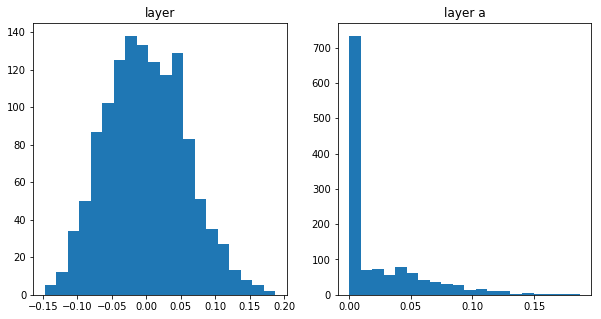

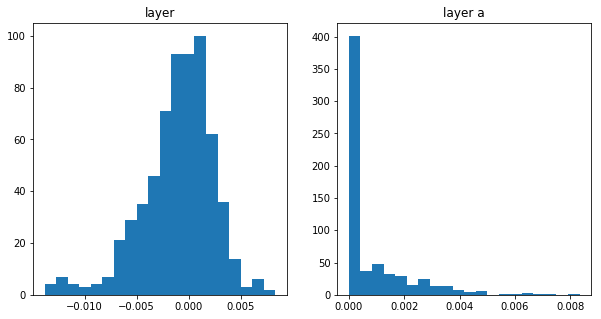

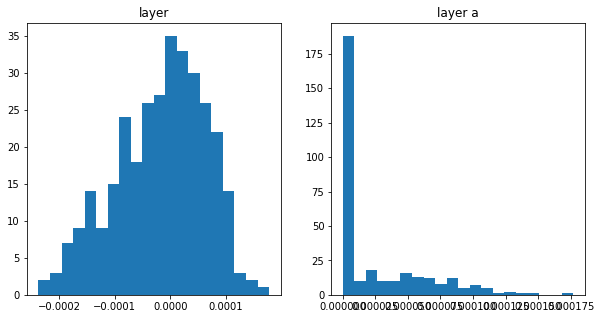

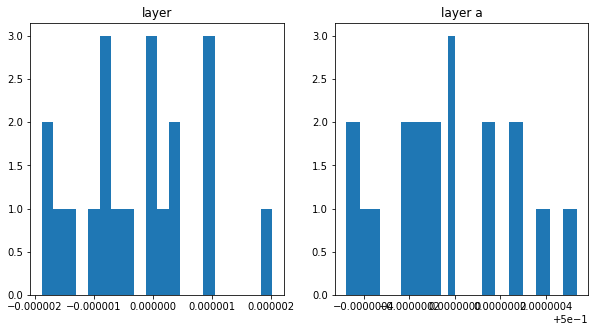

In [97]:
# feed forwward operation without batch norm
sess.run(tf.global_variables_initializer())
layer1,layer1a = l1.feedforward(x_data)
layer2,layer2a = l2.feedforward(layer1a)
layer3,layer3a = l3.feedforward(layer2a)
layer4,layer4a = l4.feedforward(layer3a)

cost  = - tf.reduce_mean(x_label * tf.log(layer4a+1e-8) + (1-x_label) * tf.log(1-layer4a + 1e-8))
dcost = ((x_label-layer4a)/(layer4a-layer4a * layer4a))/batch_size

grad4w,grad4p = l4.backprop(dcost)
grad3w,grad3p = l3.backprop(grad4p)
grad2w,grad2p = l2.backprop(grad3p)
grad1w,grad1p = l1.backprop(grad2p)

# evaluate all of the layers
layer1,layer1a=layer1.eval(),layer1a.eval()
layer2,layer2a=layer2.eval(),layer2a.eval()
layer3,layer3a=layer3.eval(),layer3a.eval()
layer4,layer4a=layer4.eval(),layer4a.eval()

grad4w,grad4p = grad4w.eval(),grad4p.eval()
grad3w,grad3p = grad3w.eval(),grad3p.eval()
grad2w,grad2p = grad2w.eval(),grad2p.eval()
grad1w,grad1p = grad1w.eval(),grad1p.eval()

plt.figure(figsize=(10,5))
plt.subplot(121); plt.hist(layer1. ravel(),batch_size); plt.title('layer')
plt.subplot(122); plt.hist(layer1a.ravel(),batch_size); plt.title('layer a')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121); plt.hist(layer2. ravel(),batch_size); plt.title('layer')
plt.subplot(122); plt.hist(layer2a.ravel(),batch_size); plt.title('layer a')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121); plt.hist(layer3. ravel(),batch_size); plt.title('layer')
plt.subplot(122); plt.hist(layer3a.ravel(),batch_size); plt.title('layer a')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121); plt.hist(layer4. ravel(),batch_size); plt.title('layer')
plt.subplot(122); plt.hist(layer4a.ravel(),batch_size); plt.title('layer a')
plt.show()

# Reference
1. generator, B. (2018). Bernoulli random number generator. Stack Overflow. Retrieved 14 December 2018, from https://stackoverflow.com/questions/47012474/bernoulli-random-number-generator
2. right?, D. (2018). Derivative of Binary Cross Entropy - why are my signs not right?. Mathematics Stack Exchange. Retrieved 14 December 2018, from https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right
3. 